# 基本定义

In [3]:
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import time
import pickle

In [4]:
# Load all necessary modules here, for clearness
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# from torchvision.datasets import MNIST
import torchvision
from torchvision import transforms
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt

## 数据集/模型

### MLP + MNIST

In [41]:
# MLP
optConfig = {
    'honestSize': 50,
    'byzantineSize': 20,

    'rounds': 15,
    'displayInterval': 1000,

    'weight_decay': 0.00,
    
    'fixSeed': False,
    'SEED': 100,
    
    'batchSize': 5,
    'shuffle': True,
}

# 数据集属性
dataSetConfig = {
    'name': 'mnist',

    'dataSet' : 'mnist',
    'dataSetSize': 60000,
    'maxFeature': 784,

    'honestNodeSize': 50,
    'byzantineNodeSize': 20,

    'rounds': 15,
    'displayInterval': 1000,
}

SGDConfig = optConfig.copy()
SGDConfig['gamma'] = 1e-1

batchConfig = optConfig.copy()
batchConfig['batchSize'] = 50
batchConfig['gamma'] = 5e-1

SVRGConfig = optConfig.copy()
SVRGConfig['snapshotInterval'] = dataSetConfig['dataSetSize']
SVRGConfig['gamma'] = 1e-1

SAGAConfig = optConfig.copy()
SAGAConfig['gamma'] = 1e-1

SARAHConfig = optConfig.copy()
SARAHConfig['gamma'] = 1e-1

# 加载数据集
train_transform = transforms.Compose([
    transforms.ToTensor(), # Convert a PIL Image or numpy.ndarray to tensor.
    # Normalize a tensor image with mean 0.1307 and standard deviation 0.3081
    transforms.Normalize((0.1307,), (0.3081,))
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
train_dataset = torchvision.datasets.MNIST(root='./dataset/', 
                            train=True, 
                            transform=train_transform,
                            download=False)
validate_dataset = torchvision.datasets.MNIST(root='./dataset/', 
                           train=False, 
                           transform=test_transform,
                           download=False)

# 模型
class MLP(nn.Module):
    """
    Inputs                Linear/Function        Output
    [128, 1, 28, 28]   -> Linear(28*28, 100) -> [128, 100]  # first hidden layer
                       -> ReLU               -> [128, 100]  # relu activation function, may sigmoid
                       -> Linear(100, 100)   -> [128, 100]  # third hidden layer
                       -> ReLU               -> [128, 100]  # relu activation function, may sigmoid
                       -> Linear(100, 10)    -> [128, 10]   # Classification Layer                                                          
   """
    def __init__(self, input_size, hidden_size, output_size, SEED=100):
        super(MLP, self).__init__()
        self.hidden = nn.Linear(input_size, hidden_size)
        self.classification_layer = nn.Linear(hidden_size, output_size)
        
        self.relu1 = nn.Tanh()
        self.relu2 = nn.Tanh()
        
        self.softmax = nn.Softmax(dim=1)
#         self.relu1 = nn.ReLU()
#         self.relu2 = nn.ReLU()
        
#         torch.manual_seed(SEED)#为CPU设置随机种子
#         model = local_models[0]
#         for p in model.parameters():
#             torch.nn.init.normal_(p, mean=0, std=2/p.numel())
        
    def forward(self, x):
        """Defines the computation performed at every call.
           Should be overridden by all subclasses.
        Args:
            x: [batch_size, channel, height, width], input for network
        Returns:
            out: [batch_size, n_classes], output from network
        """
        
        out = x.view(x.size(0), -1) # flatten x in [128, 784]
        out = self.relu1(out)
        out = self.hidden(out)
        out = self.relu2(out)
        out = self.classification_layer(out)
        out = self.softmax(out)
        return out
    
# 模型工厂
def modelFactory(SEED=100):
    return MLP(784, 50, 10)

### ResNet + CIFAR10

In [11]:
# # ResNet50 + CIFAR10
# optConfig = {
#     'honestSize': 10,
#     'byzantineSize': 4,

#     'rounds': 15,
#     'displayInterval': 6000,
    
#     'weight_decay': 0.0001,
    
#     'fixSeed': False,
#     'SEED': 100,
    
#     'batchSize': 5,
#     'shuffle': True,
# }

# SGDConfig = optConfig.copy()
# SGDConfig['gamma'] = 1e-1

# batchConfig = optConfig.copy()
# batchConfig['batchSize'] = 50
# batchConfig['gamma'] = 5e-1

# SVRGConfig = optConfig.copy()
# SVRGConfig['snapshotInterval'] = dataSetConfig['dataSetSize']
# SVRGConfig['gamma'] = 1e-1

# SAGAConfig = optConfig.copy()
# SAGAConfig['gamma'] = 1e-1

# SARAHConfig = optConfig.copy()
# SARAHConfig['gamma'] = 1e-1

# # 数据集属性
# dataSetConfig = {
#     'name': 'CIFAR-10',

#     'dataSet' : 'CIFAR-10',
#     'dataSetSize': 60000,
#     'maxFeature': 32*32*3,
# }

# # 加载数据集
# preprocess = transforms.Compose([
#     transforms.Resize(256),
#     transforms.CenterCrop(224),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
# ])
# train_dataset = torchvision.datasets.CIFAR10(root='./dataset/',
#                                              train=True, 
#                                              transform=preprocess,
#                                              download=False)
# validate_dataset = torchvision.datasets.CIFAR10(root='./dataset/',
#                                             train=False, 
#                                             transform=preprocess)

# 模型工厂
# def modelFactory(SEED=100):
#     return torchvision.models.resnet50()

## 运行参数

In [20]:
CACHE_DIR = './cache/' + dataSetConfig['name'] + '_'

In [21]:
device = 'cuda:0'

## 辅助函数

In [22]:
# 报告函数
def log(*k, **kw):
    timeStamp = time.strftime('[%m-%d %H:%M:%S] ', time.localtime())
    print(timeStamp, end='')
    print(*k, **kw)
def debug(*k, **kw):
    timeStamp = time.strftime('[%m-%d %H:%M:%S] (debug)', time.localtime())
    print(timeStamp, end='')
    print(*k, **kw)

## 损失函数

In [23]:
loss_func = torch.nn.CrossEntropyLoss()

In [24]:
def getVarience(w_local, honestSize):
    avg = w_local[:honestSize].mean(dim=0)
    s = 0
    for w in w_local[:honestSize]:
        s += (w - avg).norm()**2
    s /= honestSize
    return s.item()

In [25]:
def calculateAccuracy(model, loader, device):
    loss = 0
    accuracy = 0
    total = 0
    
    for material, targets in loader:
        material, targets = material.to(device), targets.to(device)
        outputs = model(material)
        
        l = loss_func(outputs, targets)

        loss += l.item() * len(targets)
        _, predicted = torch.max(outputs.data, dim=1)
        accuracy += (predicted == targets).sum().item()
        total += len(targets)
    
    loss /= total
    accuracy /= total
    
    return loss, accuracy

## 聚合函数

In [26]:
def mean(wList):
    return torch.mean(wList, dim=0)

In [27]:
def gm(wList):
    max_iter = 80
    tol = 1e-5
    guess = torch.mean(wList, dim=0)
    for _ in range(max_iter):
        dist_li = torch.norm(wList-guess, dim=1)
        for i in range(len(dist_li)):
            if dist_li[i] == 0:
                dist_li[i] = 1
        temp1 = torch.sum(torch.stack([w/d for w, d in zip(wList, dist_li)]), dim=0)
        temp2 = torch.sum(1/dist_li)
        guess_next = temp1 / temp2
        guess_movement = torch.norm(guess - guess_next)
        guess = guess_next
        if guess_movement <= tol:
            break
    return guess

In [28]:
def Krum_(nodeSize, byzantineSize):
    honestSize = nodeSize - byzantineSize
    dist = torch.zeros(nodeSize, nodeSize, dtype=torch.float32)
    def Krum(wList):
        for i in range(nodeSize):
            for j in range(i, nodeSize):
                distance = wList[i].data - wList[j].data
                distance = (distance*distance).sum()
                dist[i][j] = distance.data
                dist[j][i] = distance.data
        k = nodeSize - byzantineSize - 2 + 1 # 算上自己和自己的0.00
        topv, _ = dist.topk(k=k, dim=1)
        sumdist = -topv.sum(dim=1)
        resindex = sumdist.topk(1)[1].squeeze()
        return wList[resindex]
    return Krum

In [29]:
def median(wList):
    return wList.median(dim=0)[0]

## torch辅助函数

In [30]:
def flatten_list(message, byzantineSize):
    wList = [torch.cat([p.flatten() for p in parameters]) for parameters in message]
    wList.extend([torch.zeros_like(wList[0]) for _ in range(byzantineSize)])
    wList = torch.stack(wList)
    return wList
def unflatten_vector(vector, model):
    paraGroup = []
    cum = 0
    for p in model.parameters():
        newP = vector[cum:cum+p.numel()]
        paraGroup.append(newP.view_as(p))
        cum += p.numel()
    return paraGroup

In [31]:
def randomSample(dataset, batchSize):
    m, t = zip(*random.sample(dataset, batchSize))
    material, targets = torch.cat(m), torch.tensor(t)
    return material, targets

In [32]:
def getPara(module, useString=True):
    para = sum([x.nelement() for x in module.parameters()])
    if not useString:
        return para
    elif para >= 2**20:
        return '{:.2f}M'.format(para / 2**20)
    elif para >= 2**10:
        return '{:.2f}K'.format(para / 2**10)
    else:
        return str(para)

# 优化算法

报告函数

In [33]:
def report(r, rounds, displayInterval, trainLoss, trainAccuracy, valLoss, valAccuracy, var=None):
    varStr = '' if (var == None) else ' var={:.2e}'.format(var)
    log('[{}/{}](interval: {:.0f}) train: loss={:.4f} acc={:.2f} val: loss={:.4f} acc={:.2f}{}'
        .format(r, rounds, displayInterval, trainLoss, trainAccuracy, valLoss, valAccuracy, varStr)
    )

## CentralSGD

In [34]:
def CentralSGD(model, gamma, aggregate, weight_decay, attack=None, 
          rounds=10, displayInterval=1000, 
          device='cpu', SEED=100, fixSeed=False, 
          batchSize=1,
          **kw):
    if fixSeed:
        random.seed(SEED)

    # 顺序遍历loader
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batchSize, shuffle=False)
    validate_loader = torch.utils.data.DataLoader(dataset=validate_dataset, batch_size=batchSize, shuffle=False)

    # 随机取样器
    randomSampler = torch.utils.data.sampler.RandomSampler(
        train_dataset, 
        num_samples=rounds*displayInterval*batchSize, 
        replacement=True
    )
    train_random_loader = torch.utils.data.DataLoader(
        dataset=train_dataset,
        batch_size=batchSize, 
        sampler=randomSampler,
    )
    randomIter = iter(train_random_loader)
    
    # 求初始误差
    trainLoss, trainAccuracy = calculateAccuracy(model, train_loader, device)
    valLoss, valAccuracy = calculateAccuracy(model, validate_loader, device)

    trainLossPath = [trainLoss]
    trainAccPath = [trainAccuracy]
    valLossPath = [valLoss]
    valAccPath = [valAccuracy]
    
    report(0, rounds, displayInterval, trainLoss, trainAccuracy, valLoss, valAccuracy)

    for r in range(rounds):
        model.train()
        for k in range(displayInterval):
            # 读取数据
            material, targets = next(randomIter)
            material, targets = material.to(device), targets.to(device)

            # 随机梯度
            # --------------------
            # 预测
            outputs = model(material)
            loss = loss_func(outputs, targets)
            # 反向传播
            model.zero_grad()
            loss.backward()

            # 更新
            for para in model.parameters():
                para.data.add_(-gamma, para.grad)
                para.data.add_(-weight_decay, para)
        
        
        model.eval()
        trainLoss, trainAccuracy = calculateAccuracy(model, train_loader, device)
        valLoss, valAccuracy = calculateAccuracy(model, validate_loader, device)

        trainLossPath.append(trainLoss)
        trainAccPath.append(trainAccuracy)
        valLossPath.append(valLoss)
        valAccPath.append(valAccuracy)

        report(r+1, rounds, displayInterval, trainLoss, trainAccuracy, valLoss, valAccuracy)
    return model, trainLossPath, trainAccPath, valLossPath, valAccPath, []

## Central SARAH

In [37]:
def CentralSARAH(model, gamma, aggregate, weight_decay, 
          snapshotInterval=len(train_dataset),
          rounds=10, displayInterval=1000, 
          device='cpu', SEED=100, fixSeed=False, 
          batchSize=5,
          **kw):
    
    if fixSeed:
        random.seed(SEED)
    
    # 初始化模型
    lastModel = modelFactory(SEED=SEED)
    lastModel = lastModel.to(device)

    # 随机的停止期限
    randomStop = 1
    
    # 顺序遍历loader
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batchSize, shuffle=False)
    validate_loader = torch.utils.data.DataLoader(dataset=validate_dataset, batch_size=batchSize, shuffle=False)
    
    # 随机取样器
    randomSampler = torch.utils.data.sampler.RandomSampler(
        train_dataset, 
        num_samples=rounds*displayInterval*batchSize, 
        replacement=True
    )
    randomLoader = torch.utils.data.DataLoader(
        dataset=train_dataset,
        batch_size=batchSize, 
        sampler=randomSampler,
    )
    randomIter = iter(randomLoader)
    
    # 求初始误差
    trainLoss, trainAccuracy = calculateAccuracy(model, train_loader, device)
    valLoss, valAccuracy = calculateAccuracy(model, validate_loader, device)
    
    trainLossPath = [trainLoss]
    trainAccPath = [trainAccuracy]
    valLossPath = [valLoss]
    valAccPath = [valAccuracy]
    
    log('[SARAH]初始 train: loss={:.6f} accuracy={:.2f} validation: loss={:.6f} accuracy={:.2f}'
        .format(trainLossPath[0], trainAccPath[0], valLossPath[0], valAccPath[0])
    )

    gradients = [torch.zeros_like(para, requires_grad=False) for para in model.parameters()]
    
    for r in range(rounds):
        for k in range(displayInterval):
            # snapshot
            if (r*displayInterval + k) % randomStop == 0:
                # 清空旧梯度
                for grad in gradients:
                    grad.zero_()
                for material, targets in train_loader:
                    material, targets = material.to(device), targets.to(device)
                    # 预测
                    outputs = model(material)
                    loss = loss_func(outputs, targets)
                    # 反向传播
                    model.zero_grad()
                    loss.backward()

                    for grad, para in zip(gradients, model.parameters()):
                        grad.data.add_(1/len(train_loader), para.grad.data)
                for grad, para in zip(gradients, model.parameters()):
                    grad.data.add_(weight_decay, para.data)
                
                # 保存旧结果
                for oldPara, newPara in zip(lastModel.parameters(), model.parameters()):
                    oldPara.data.copy_(newPara)
                # 更新
                for para, grad in zip(model.parameters(), gradients):
                    para.data.add_(-gamma, grad)
                # 指定下一次停止时间
                randomStop = random.randint(1, snapshotInterval-1)
                
            # 更新
            # 读取数据
            material, targets = next(randomIter)
            material, targets = material.to(device), targets.to(device)

            # 随机梯度
            # --------------------
            # 预测
            outputs = model(material)
            loss = loss_func(outputs, targets)
            # 反向传播
            model.zero_grad()
            loss.backward()

            # 修正梯度
            # --------------------
            # 预测
            outputs = lastModel(material)
            loss = loss_func(outputs, targets)
            # 反向传播
            lastModel.zero_grad()
            loss.backward()

            # 更新梯度表
            for pi, para in enumerate(model.parameters()):
                gradients[pi].data.add_(1, para.grad.data)
                gradients[pi].data.add_(weight_decay, para)
            for pi, para in enumerate(lastModel.parameters()):
                gradients[pi].data.sub_(1, para.grad.data)
                gradients[pi].data.sub_(weight_decay, para)

            # 保存旧结果
            for oldPara, newPara in zip(lastModel.parameters(), model.parameters()):
                oldPara.data.copy_(newPara)
            # 更新
            for para, grad in zip(model.parameters(), gradients):
                para.data.add_(-gamma, grad)
  
        trainLoss, trainAccuracy = calculateAccuracy(model, train_loader, device)
        valLoss, valAccuracy = calculateAccuracy(model, validate_loader, device)

        trainLossPath.append(trainLoss)
        trainAccPath.append(trainAccuracy)
        valLossPath.append(valLoss)
        valAccPath.append(valAccuracy)
        
        report(r+1, rounds, displayInterval, trainLoss, trainAccuracy, valLoss, valAccuracy)
    return model, trainLossPath, trainAccPath, valLossPath, valAccPath, []

## SGD

In [25]:
def SGD(model, gamma, aggregate, weight_decay, 
          honestSize=0, byzantineSize=0, attack=None, 
          rounds=10, displayInterval=1000, 
          device='cpu', SEED=100, fixSeed=False, 
          batchSize=5,
          **kw):
    assert byzantineSize == 0 or attack != None
    assert honestSize != 0
    
    if fixSeed:
        random.seed(SEED)

    nodeSize = honestSize + byzantineSize

    # 数据分片
    pieces = [(i*len(train_dataset)) // honestSize for i in range(honestSize+1)]
    dataPerNode = [pieces[i+1] - pieces[i] for i in range(honestSize)]

    # 回复的消息
    message = [
        [torch.zeros_like(para, requires_grad=False) for para in model.parameters()]
        for _ in range(nodeSize)
    ]
    
    # 顺序遍历loader
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batchSize, shuffle=False)
    validate_loader = torch.utils.data.DataLoader(dataset=validate_dataset, batch_size=batchSize, shuffle=False)
    
    train_dataset_subset = [torch.utils.data.Subset(train_dataset, range(pieces[i], pieces[i+1])) for i in range(honestSize)]
    train_loaders_splited = [
        torch.utils.data.DataLoader(dataset=subset, batch_size=batchSize, shuffle=False)
        for subset in train_dataset_subset
    ]
    
    # 随机取样器
    randomSampler = torch.utils.data.sampler.RandomSampler(
        train_dataset, 
        num_samples=rounds*displayInterval*batchSize, 
        replacement=True
    )
    train_random_loaders_splited = [torch.utils.data.DataLoader(
            dataset=subset,
            batch_size=batchSize, 
            sampler=randomSampler,
    ) for subset in train_dataset_subset]
    randomIters = [iter(loader) for loader in train_random_loaders_splited]
    
    # 求初始误差
    trainLoss, trainAccuracy = calculateAccuracy(model, train_loader)
    valLoss, valAccuracy = calculateAccuracy(model, validate_loader)
    
    trainLossPath = [trainLoss]
    trainAccPath = [trainAccuracy]
    valLossPath = [valLoss]
    valAccPath = [valAccuracy]
    variencePath = []
    
    report(0, rounds, displayInterval, trainLoss, trainAccuracy, valLoss, valAccuracy)

    for r in range(rounds):
        for k in range(displayInterval):
            # 诚实节点更新
            for node in range(honestSize):
                # 读取数据
                material, targets = next(randomIters[node])
                
                # 随机梯度
                # --------------------
                # 预测
                outputs = model(material)
                loss = loss_func(outputs, targets)
                # 反向传播
                model.zero_grad()
                loss.backward()

                # 更新梯度表
                for pi, para in enumerate(model.parameters()):
                    message[node][pi].data.zero_()
                    message[node][pi].data.add_(1, para.grad.data)
                    message[node][pi].data.add_(weight_decay, para)

            # 同步, Byzantine攻击
            message_f = flatten_list(message, byzantineSize)
            if attack != None:
                attack(message_f, byzantineSize)
            # 聚合
            g_vector = aggregate(message_f)
            # 展开
            g = unflatten_vector(g_vector, model)
            # 更新
            for para, grad in zip(model.parameters(), g):
                para.data.add_(-gamma, grad)
  
        var = getVarience(message_f, honestSize)
        variencePath.append(var)
        
        trainLoss, trainAccuracy = calculateAccuracy(model, train_loader)
        valLoss, valAccuracy = calculateAccuracy(model, validate_loader)

        trainLossPath.append(trainLoss)
        trainAccPath.append(trainAccuracy)
        valLossPath.append(valLoss)
        valAccPath.append(valAccuracy)
        
        report(r+1, rounds, displayInterval, trainLoss, trainAccuracy, valLoss, valAccuracy)
    return model, trainLossPath, trainAccPath, valLossPath, valAccPath, variencePath

## SAGA

In [26]:
# 初始化本地模型
def initModel(local_models, honestSize):
    stateDict = local_models[0].state_dict()
    for model in local_models[1:honestSize]:
        model.load_state_dict(stateDict)

# 广播
def broadcastPara(newPara, local_models):
    cum = 0
    for p in local_models[0].parameters():
        newP = newPara[cum:cum+p.numel()]
        p.data.copy_(newP.view_as(p))
        cum += p.numel()
    stateDict = local_models[0].state_dict()
    for model in local_models[1:]:
        model.load_state_dict(stateDict)

In [27]:
def SAGA(w0, gamma, aggregate, weight_decay, honestSize=0, byzantineSize=0, attack=None, 
            rounds=10, displayInterval=1000, SEED=100, fixSeed=False, **kw):
    assert byzantineSize == 0 or attack != None
    assert honestSize != 0
    
    if fixSeed:
        random.seed(SEED)

    nodeSize = honestSize + byzantineSize
    
    log('开始迭代，gamma={}'.format(gamma))
    
    # 初始化
    store = []

    # 中间变量分配空间
    local_models = [modelFactory(SEED=SEED) for _ in range(honestSize+byzantineSize)]
    # 同步初始化参数
    initModel(local_models, honestSize=honestSize)

    torch.manual_seed(SEED)#为CPU设置随机种子
    # torch.cuda.manual_seed(seed)#为当前GPU设置随机种子
    # torch.cuda.manual_seed_all(seed)#为所有GPU设置随机种子
    
    trainLoss = 0
    trainAccuracy = 0
    total = 0
    ANY_MODEL_IS_OK = 0
    for index, (material, targets) in enumerate(dataset):
        outputs = local_models[ANY_MODEL_IS_OK](material)

        loss = loss_func(outputs, targets)

        trainLoss += loss.item() * len(targets)
        _, predicted = torch.max(outputs.data, dim=1)
        trainAccuracy += (predicted == targets).sum().item()
        total += len(targets)

        local_models[0].zero_grad()
        loss.backward()

        store.append([p.grad.clone().detach()+weight_decay*p.data for p in local_models[0].parameters()])

    # 数据分片
    pieces = [(i*len(dataset)) // honestSize for i in range(honestSize+1)]
    dataPerNode = [pieces[i+1] - pieces[i] for i in range(honestSize)]

    # G_avg每一行是单个节点上存储的均值
    G_avg = []
    for i in range(honestSize):
        # storeInThisNode：该节点上梯度缓存的集合
        storeInThisNode = store[pieces[i]: pieces[i+1]]
        # para每一个元素是在对应节点上的一组参数
        (*paras,) = zip(*storeInThisNode)
        # 对所有单一节点上所有数据求平均
        G_avg.append([sum(para)/(pieces[i+1]-pieces[i]) for para in paras])

    # dataset按批划分，每批求出来的Loss已经求平均，只需要在批间求平均即可
    trainLoss /= total
    trainAccuracy /= total
    lossPath = [trainLoss]
    accPath = [trainAccuracy]
    log('[SAGA]初始 loss={:.6f}, accuracy={:.2f}'.format(lossPath[0], accPath[0]))

    for r in range(rounds):
        trainLoss = 0
        trainAccuracy = 0
        total = 0

        for k in range(displayInterval):
            # 诚实节点更新
            for node in range(honestSize):
                model = local_models[node]
                # 读取数据
                index = random.randint(pieces[node], pieces[node+1]-1)
                # 预测
                material, targets = dataset[index]
                outputs = model(material)
                loss = loss_func(outputs, targets)
                # 统计准确率
                trainLoss += loss.item() * len(targets)
                _, predicted = torch.max(outputs.data, dim=1)
                trainAccuracy += (predicted == targets).sum().item()
                total += len(targets)
                # 反向传播
                model.zero_grad()
                loss.backward()

                # 更新梯度表
                for pi, para in enumerate(model.parameters()):
                    old_G = store[index][pi]
                    new_G = para.grad.data.clone()
                    new_G.add_(weight_decay, para.data)

                    gradient = new_G.data - old_G.data + G_avg[node][pi].data

                    G_avg[node][pi].add_(1 / dataPerNode[node],
                                     new_G.data - old_G.data)
                    store[index][pi] = new_G.data

                    para.data.add_(-gamma, gradient.data)

            # Byzantine攻击
            if attack != None:
                attack(local_models, byzantineSize)
            # 聚合
            aggregatedPara = aggregate(local_models)

            # 广播
            broadcastPara(newPara=aggregatedPara, local_models=local_models)

        trainLoss /= total
        trainAccuracy /= total
        lossPath.append(trainLoss)
        accPath.append(trainAccuracy)
        log('[SAGA]已迭代 {}/{} rounds (interval: {:.0f}), loss={:.9f}, accuracy={:.2f}'.format(
            r+1, rounds, displayInterval, trainLoss, trainAccuracy
        ))
    return local_models[0], lossPath, accPath

## SVRG

In [28]:
def SVRG(w0, gamma, aggregate, weight_decay, honestSize=0, byzantineSize=0, attack=None, 
            snapshotInterval=6000, rounds=10, displayInterval=1000, SEED=100, fixSeed=False, **kw):
    assert byzantineSize == 0 or attack != None
    assert honestSize != 0
    
    if fixSeed:
        random.seed(SEED)

    nodeSize = honestSize + byzantineSize
    
    # 初始化
    w = w0.clone().detach()

    # 数据分片
    pieces = [(i*len(dataset)) // honestSize for i in range(honestSize+1)]
    dataPerNode = [pieces[i+1] - pieces[i] for i in range(honestSize)]

    snapshot_g = torch.zeros(honestSize, len(w0), dtype=torch.float64)
    snapshot_w = torch.zeros(len(w0), dtype=torch.float64)

    path = [F(w, dataset, weight_decay)]
    variencePath = []
    log('[SVRG]初始 loss={:.6f}, accuracy={:.2f} gamma={:}'.format(path[0], accuracy(w, dataset), gamma))
    
    # 中间变量分配空间
    message = torch.zeros(nodeSize, len(w0), dtype=torch.float64)

    log('开始迭代')
    for r in range(rounds):
        for k in range(displayInterval):
            # snapshot
            if (r*displayInterval + k) % snapshotInterval == 0:
                snapshot_g.zero_()
                for node in range(honestSize):
                    for index in range(pieces[node], pieces[node+1]):
                        x, y = dataset[index]
                        # 更新梯度表
                        predict = LogisticRegression(w, x)

                        err = (predict-y).data
                        snapshot_g[node][:-1].add_(1/dataPerNode[node], err*x)
                        snapshot_g[node][-1].add_(1/dataPerNode[node], err)
                    snapshot_g[node].add_(weight_decay, w)
                snapshot_w.copy_(w)
            
            # 诚实节点更新
            message.zero_()
            for node in range(honestSize):
                index = random.randint(pieces[node], pieces[node+1]-1)

                x, y = dataset[index]
                # 随机梯度
                predict = LogisticRegression(w, x)
                err = (predict-y).data
                message[node][:-1].add_(err, x)
                message[node][-1].add_(err, 1)
                message[node].add_(weight_decay, w)
                
                # 修正梯度
                predict = LogisticRegression(snapshot_w, x)
                err = (predict-y).data
                message[node][:-1].add_(-err, x)
                message[node][-1].add_(-err, 1)
                message[node].add_(-weight_decay, snapshot_w)
                
                message[node].add_(1, snapshot_g[node])
                
            # 同步
            # Byzantine攻击
            if attack != None:
                attack(message, byzantineSize)
            g = aggregate(message)
            w.add_(-gamma, g)
            
        loss = F(w, dataset, weight_decay)
        acc = accuracy(w, dataset)
        path.append(loss)
        var = getVarience(message, honestSize)
        variencePath.append(var)
        log('[SVRG]已迭代 {}/{} rounds (interval: {:.0f}), loss={:.9f}, accuracy={:.2f}, var={:.9f}'.format(
            r+1, rounds, displayInterval, loss, acc, var
        ))
    return w, path, variencePath

## SARAH

In [29]:
def SARAH(model, gamma, aggregate, weight_decay, 
          snapshotInterval=len(train_dataset),
          honestSize=0, byzantineSize=0, attack=None, 
          rounds=10, displayInterval=1000, 
          device='cpu', SEED=100, fixSeed=False, 
          batchSize=5,
          **kw):
    assert byzantineSize == 0 or attack != None
    assert honestSize != 0
    
    if fixSeed:
        random.seed(SEED)

    nodeSize = honestSize + byzantineSize
    
    # 初始化模型
    lastModel = modelFactory(SEED=SEED)

    if device == 'cpu':
        torch.manual_seed(SEED)#为CPU设置随机种子
    else:
        torch.cuda.manual_seed(seed)#为当前GPU设置随机种子
        torch.cuda.manual_seed_all(seed)#为所有GPU设置随机种子
    
    # 数据分片
    pieces = [(i*len(train_dataset)) // honestSize for i in range(honestSize+1)]
    dataPerNode = [pieces[i+1] - pieces[i] for i in range(honestSize)]

    # 随机的停止期限
    randomStop = 1
    # 回复的消息
    message = [
        [torch.zeros_like(para, requires_grad=False) for para in model.parameters()]
        for _ in range(nodeSize)
    ]
    
    # 顺序遍历loader
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batchSize, shuffle=False)
    validate_loader = torch.utils.data.DataLoader(dataset=validate_dataset, batch_size=batchSize, shuffle=False)
    
    train_dataset_subset = [torch.utils.data.Subset(train_dataset, range(pieces[i], pieces[i+1])) for i in range(honestSize)]
    train_loaders_splited = [
        torch.utils.data.DataLoader(dataset=subset, batch_size=batchSize, shuffle=False)
        for subset in train_dataset_subset
    ]
    
    # 随机取样器
    randomSampler = torch.utils.data.sampler.RandomSampler(
        train_dataset, 
        num_samples=rounds*displayInterval*batchSize, 
        replacement=True
    )
    train_random_loaders_splited = [torch.utils.data.DataLoader(
            dataset=subset,
            batch_size=batchSize, 
            sampler=randomSampler,
    ) for subset in train_dataset_subset]
    randomIters = [iter(loader) for loader in train_random_loaders_splited]
    
    # 求初始误差
    trainLoss, trainAccuracy = calculateAccuracy(model, train_loader)
    valLoss, valAccuracy = calculateAccuracy(model, validate_loader)
    
    trainLossPath = [trainLoss]
    trainAccPath = [trainAccuracy]
    valLossPath = [valLoss]
    valAccPath = [valAccuracy]
    variencePath = []
    
    log('[SARAH]初始 train: loss={:.6f} accuracy={:.2f} validation: loss={:.6f} accuracy={:.2f}'
        .format(trainLossPath[0], trainAccPath[0], valLossPath[0], valAccPath[0])
    )

    for r in range(rounds):
        for k in range(displayInterval):
            # snapshot
            if (r*displayInterval + k) % randomStop == 0:
                for node in range(honestSize):
                    # 清空旧梯度
                    for grad in message[node]:
                        grad.zero_()
                    loader = train_loaders_splited[node]
                    for material, targets in loader:
                        # 预测
                        outputs = model(material)
                        loss = loss_func(outputs, targets)
                        # 反向传播
                        model.zero_grad()
                        loss.backward()
                        
                        for grad, para in zip(message[node], model.parameters()):
                            grad.data.add_(1/len(loader), para.grad.data)
                    for grad, para in zip(message[node], model.parameters()):
                        grad.data.add_(weight_decay, para.data)
                
                # 保存旧结果
                for oldPara, newPara in zip(lastModel.parameters(), model.parameters()):
                    oldPara.data.copy_(newPara)
                # 同步, Byzantine攻击
                message_f = flatten_list(message, byzantineSize)
                if attack != None:
                    attack(message_f, byzantineSize)
                # 聚合
                g_vector = aggregate(message_f)
                # 展开
                g = unflatten_vector(g_vector, model)
                # 更新
                for para, grad in zip(model.parameters(), g):
                    para.data.add_(-gamma, grad)
                # 指定下一次停止时间
                randomStop = random.randint(1, snapshotInterval-1)
                
            # 诚实节点更新
            for node in range(honestSize):
                # 读取数据
                material, targets = next(randomIters[node])
                
                # 随机梯度
                # --------------------
                # 预测
                outputs = model(material)
                loss = loss_func(outputs, targets)
                # 反向传播
                model.zero_grad()
                loss.backward()
                
                # 修正梯度
                # --------------------
                # 预测
                outputs = lastModel(material)
                loss = loss_func(outputs, targets)
                # 反向传播
                lastModel.zero_grad()
                loss.backward()

                # 更新梯度表
                for pi, para in enumerate(model.parameters()):
                    message[node][pi].data.add_(1, para.grad.data)
                    message[node][pi].data.add_(weight_decay, para)
                for pi, para in enumerate(lastModel.parameters()):
                    message[node][pi].data.sub_(1, para.grad.data)
                    message[node][pi].data.sub_(weight_decay, para)

            # 同步, Byzantine攻击
            message_f = flatten_list(message, byzantineSize)
            if attack != None:
                attack(message_f, byzantineSize)
            # 聚合
            g_vector = aggregate(message_f)
            # 展开
            g = unflatten_vector(g_vector, model)
            # 保存旧结果
            for oldPara, newPara in zip(lastModel.parameters(), model.parameters()):
                oldPara.data.copy_(newPara)
            # 更新
            for para, grad in zip(model.parameters(), g):
                para.data.add_(-gamma, grad)
  
        var = getVarience(message_f, honestSize)
        variencePath.append(var)
        
        trainLoss, trainAccuracy = calculateAccuracy(model, train_loader)
        valLoss, valAccuracy = calculateAccuracy(model, validate_loader)

        trainLossPath.append(trainLoss)
        trainAccPath.append(trainAccuracy)
        valLossPath.append(valLoss)
        valAccPath.append(valAccuracy)
        
        report(r+1, rounds, displayInterval, trainLoss, trainAccuracy, valLoss, valAccuracy)
    return model, trainLossPath, trainAccPath, valLossPath, valAccPath, variencePath

# 恶意攻击

In [30]:
def white(messages, byzantinesize):
    # 均值相同，方差为1
    mu = torch.mean(messages[0:-byzantinesize], dim=0)
    messages[-byzantinesize:].copy_(mu)
    noise = torch.randn((byzantinesize, messages.size(1)), dtype=torch.float64)
#     messages[-byzantinesize:].add_(35, noise)
    messages[-byzantinesize:].add_(1, noise)

def maxValue(messages, byzantinesize):
    # 4倍于正常均值的极大梯度
#     mu = torch.mean(messages[0:-byzantinesize], dim=0)
#     meliciousMessage = -3*mu
#     messages[-byzantinesize:].copy_(meliciousMessage)

    mu = torch.mean(w_local[0:-byzantinesize], dim=0)
    # 在串行实现中w_local[-1]不会随聚合改变而改变
    # w_local[-1]事实上是上一次的迭代值
    # w_local[-1] - mu是这次的改变值，即传输过来的向量的改变值
    delta = w_local[-1] - mu
    meliciousMessage = mu + 4*delta
    w_local[-byzantinesize:].copy_(meliciousMessage)

def zeroGradient(messages, byzantinesize):
    s = torch.sum(messages[0:-byzantinesize], dim=0)
    messages[-byzantinesize:].copy_(-s / byzantinesize)

# 训练函数

In [31]:
def train(model, loss_func, optimizer, trainloader, device, weight_decay):
    """
    train model using loss_fn and optimizer in an epoch.
    model: CNN networks
    train_loader: a Dataloader object with training data
    loss_func: loss function
    device: train on cpu or gpu device
    """
    model.train()
    
    trainAccuracy = 0
    trainLoss = 0
    total = 0
    
    for i, (*material, targets) in enumerate(trainloader):
        if isinstance(material, torch.Tensor):
            material = material.to(device)
        else:
            material = [m.to(device) for m in material]
        
        targets = targets.to(device)

        # forward
        outputs = model(*material)
        
        loss = loss_func(outputs, targets)
        trainLoss += loss.item()

        # backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # AdamW - https://zhuanlan.zhihu.com/p/38945390
        for group in optimizer.param_groups:
            for param in group['params']:
                param.data = param.data.add(-weight_decay * group['lr'], param.data)

        # return the maximum value of each row of the input tensor in the 
        # given dimension dim, the second return vale is the index location
        # of each maxium value found(argmax)
        _, predicted = torch.max(outputs.data, dim=1)
        trainAccuracy += (predicted == targets).sum().item()
        
        total += len(targets)
    trainAccuracy /= total
    trainLoss /= total
    return trainLoss, trainAccuracy

In [32]:
def validate(model, loss_func, validateloader, device):
    # evaluate the model
    model.eval()
    # context-manager that disabled gradient computation
    with torch.no_grad():
        # =============================================================
        valAccuracy = 0
        valLoss = 0
        total = 0
        
        for i, (*material, targets) in enumerate(trainloader):
            if isinstance(material, torch.Tensor):
                material = material.to(device)
            else:
                material = [m.to(device) for m in material]

            targets = targets.to(device)
            
            outputs = model(*material)
            
            loss = loss_func(outputs, targets)
            valLoss += loss.item()
            
            # return the maximum value of each row of the input tensor in the 
            # given dimension dim, the second return vale is the index location
            # of each maxium value found(argmax)
            _, predicted = torch.max(outputs.data, dim=1)
            valAccuracy += (predicted == targets).sum().item()
            
            total += len(targets)
        valAccuracy /= total
        valLoss /= total
    return valLoss, valAccuracy

In [33]:
def test(model, testloader, classname=None, name='default'):
    # evaluate the model
    model.eval()
    # context-manager that disabled gradient computation
    with torch.no_grad():
        result = []
        test_cnt = 0
        for i, (*material, targets) in enumerate(testloader):
            if isinstance(material, torch.Tensor):
                material = material.to(device)
            else:
                material = [m.to(device) for m in material]

            targets = targets.to(device)

            outputs = model(*material)

            _, predicted = torch.max(outputs.data, dim=1)

            result.extend(predicted)
            test_cnt += len(targets)

    if classname != None:
        result = [classname[i] for i in result]

    log('共预测{}个数据'.format(test_cnt))
    df_predict = pd.DataFrame({'id': list(range(1, len(result)+1)), 'polarity': result})
    df_predict.to_csv('{}.csv'.format(name), index=False)
    log('预测完成')
    

In [34]:
def showCurve(list_trainLoss, list_trainAccuracy, list_valLoss, list_valAccuracy):
    xAxis = list(range(len(list_trainLoss)))
    fig, axs = plt.subplots(1, 2)

    axs[0].plot(xAxis, list_trainLoss, label='train')
    axs[0].plot(xAxis, list_valLoss, label='validation')
    axs[0].set_title('Loss')

    axs[1].plot(xAxis, list_trainAccuracy, label='train')
    axs[1].plot(xAxis, list_valAccuracy, label='validation')
    axs[1].set_title('Accuracy')

    for ax in axs:
        ax.axis()
        ax.set_xlabel('epoch')
        ax.set_ylabel('{}'.format(ax.get_title()))
        ax.legend()
    fig.set_size_inches((8, 4))
    plt.subplots_adjust(wspace=0.3)
    plt.show()

# 运行函数

In [36]:
def run(optimizer, aggregate, attack, config, device='cpu'):
    # 初始化参数
    _config = config.copy()
    _config['aggregate'] = aggregate
    _config['attack'] = attack
    if attack == None:
        _config['byzantineSize'] = 0
        
    model = modelFactory(SEED=_config['SEED'])
    model = model.to(device)

    # 记录参数
    attackName = 'baseline' if attack == None else attack.__name__
    # e.g. Resnet50_SARAH(5)_baseline_mean
    title = '{}_{}({})_{}_{}'.format(
        model.__class__.__name__, 
        optimizer.__name__, 
        _config['batchSize'],
        attackName, 
        aggregate.__name__
    )
    
    # 打印运行信息
    print('[提交任务] ' + title)
    print('[运行信息]')
    print('[网络属性]   name={} parameters number={}'.format(model.__class__.__name__, getPara(model)))
    print('[优化方法]   name={} aggregation={} attack={}'.format(optimizer.__name__, aggregate.__name__, attackName))
    print('[数据集属性] name={} trainSize={} validationSize={}'.format(dataSetConfig['name'], len(train_dataset), len(validate_dataset)))
    print('[优化器设置] gamma={} weight_decay={} batchSize={}'.format(_config['gamma'], _config['weight_decay'], _config['batchSize']))
    print('[节点个数]   honestSize={}, byzantineSize={}'.format(_config['honestSize'], _config['byzantineSize']))
    print('[运行次数]   rounds={}, displayInterval={}'.format(_config['rounds'], _config['displayInterval']))
    print('[torch设置]  device={}, SEED={}, fixSeed={}'.format(device, _config['SEED'], _config['fixSeed']))
    print('-------------------------------------------')
    
    # 开始运行
    log('优化开始')
    res = optimizer(model, device=device, **_config)
    [*model, trainLossPath, trainAccPath, valLossPath, valAccPath, variencePath] = res

    record = {
        **dataSetConfig,
        **{key:(_config[key].__name__ if hasattr(_config[key], '__call__') else _config[key]) for key in _config},
        'trainLossPath': trainLossPath, 
        'trainAccPath': trainAccPath, 
        'valLossPath': valLossPath, 
        'valAccPath': valAccPath, 
        'variencePath': variencePath,
    }

    with open(CACHE_DIR + title, 'wb') as f:
        pickle.dump(record, f)
    
    _, axis = plt.subplots(1, 2)
    axis[0].plot(list(range(len(trainLossPath))), trainLossPath, label='train loss')
    axis[0].plot(list(range(len(valLossPath))), valLossPath, label='validation loss')
    axis[1].plot(list(range(len(trainAccPath))), trainAccPath, label='train accuracy')
    axis[1].plot(list(range(len(valAccPath))), valAccPath, label='validation accuracy')
    for ax in axis:
        ax.legend()
    plt.show()

# 测试

## 中心式SGD调参

[提交任务] ResNet_CentralSGD(20)_baseline_mean
[运行信息]
[网络属性]   name=ResNet parameters number=24.37M
[优化方法]   name=CentralSGD aggregation=mean attack=baseline
[数据集属性] name=CIFAR-10 trainSize=50000 validationSize=10000
[优化器设置] gamma=0.5 weight_decay=0.0001 batchSize=20
[节点个数]   honestSize=10, byzantineSize=0
[运行次数]   rounds=50, displayInterval=6000
[torch设置]  device=cuda:0, SEED=100, fixSeed=False
-------------------------------------------
[10-18 04:44:41] 优化开始
[10-18 04:46:48] [0/50](interval: 6000) train: loss=7.2064 acc=0.00 val: loss=7.2071 acc=0.00
[10-18 04:57:09] [1/50](interval: 6000) train: loss=1.1190 acc=0.62 val: loss=1.1532 acc=0.61
[10-18 05:07:29] [2/50](interval: 6000) train: loss=1.3573 acc=0.69 val: loss=1.5021 acc=0.65
[10-18 05:17:50] [3/50](interval: 6000) train: loss=0.7850 acc=0.73 val: loss=0.8774 acc=0.70
[10-18 05:28:10] [4/50](interval: 6000) train: loss=0.7875 acc=0.74 val: loss=0.9345 acc=0.70
[10-18 05:38:31] [5/50](interval: 6000) train: loss=0.4694 acc=0.84 v

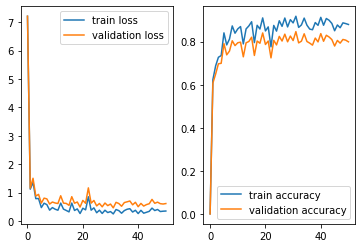

In [53]:
_config = SGDConfig.copy()
_config['gamma'] = 5e-1
_config['rounds'] = 50
_config['batchSize'] = 20
run(optimizer = CentralSGD, aggregate = mean, attack = None, config = _config, device=device)

## 中心式SARAH调参

[提交任务] ResNet_CentralSARAH(20)_baseline_mean
[运行信息]
[网络属性]   name=ResNet parameters number=24.37M
[优化方法]   name=CentralSARAH aggregation=mean attack=baseline
[数据集属性] name=CIFAR-10 trainSize=50000 validationSize=10000
[优化器设置] gamma=0.0001 weight_decay=0.0001 batchSize=20
[节点个数]   honestSize=10, byzantineSize=0
[运行次数]   rounds=30, displayInterval=100000
[torch设置]  device=cuda:0, SEED=100, fixSeed=False
-------------------------------------------
[11-03 16:27:04] 优化开始
[11-03 16:29:34] [SARAH]初始 train: loss=7.043794 accuracy=0.00 validation: loss=7.043365 accuracy=0.00
[11-03 22:11:39] [1/30](interval: 100000) train: loss=1.9613 acc=0.28 val: loss=1.9624 acc=0.28
[11-04 03:54:06] [2/30](interval: 100000) train: loss=1.8876 acc=0.31 val: loss=1.8835 acc=0.31
[11-04 09:29:13] [3/30](interval: 100000) train: loss=1.8333 acc=0.33 val: loss=1.8297 acc=0.33
[11-04 15:18:54] [4/30](interval: 100000) train: loss=1.7806 acc=0.35 val: loss=1.7777 acc=0.35
[11-04 21:16:08] [5/30](interval: 100000) tr

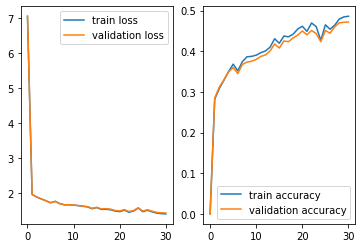

In [45]:
_config = SARAHConfig.copy()
_config['batchSize'] = 20
_config['gamma'] = 1e-4
_config['displayInterval'] = 100000
_config['rounds'] = 30
run(optimizer = CentralSARAH, aggregate = mean, attack = None, config = _config, device=device)

## SGD

### SGD - mean

In [183]:
run(optimizer = SGD, aggregate = mean, attack = None, config = SGDConfig)

[运行信息]
[优化方法]   mnist_MLP_SGD(5)_baseline_mean
[数据集属性] trainSize=500 validationSize=10000
[优化器设置] gamma=0.1 weight_decay=0.0
[节点个数]   honestSize=50, byzantineSize=0
[运行次数]   rounds=15, displayInterval=1000
[torch设置]  device=cpu, SEED=100, fixSeed=False
-------------------------------------------
[19-09-23 10:30:47] 优化开始
[19-09-23 10:30:50] [SGD]初始 train: loss=2.304678 accuracy=0.13 validation: loss=2.304778 accuracy=0.11
[19-09-23 10:31:48] [SARAH]已迭代 1/15 rounds (interval: 1000), 
train: loss=1.643265 accuracy=0.91 validation: loss=1.796671 accuracy=0.74 variance=3.23e-01
[19-09-23 10:32:46] [SARAH]已迭代 2/15 rounds (interval: 1000), 
train: loss=1.529517 accuracy=0.96 validation: loss=1.718004 accuracy=0.79 variance=6.34e-02
[19-09-23 10:33:44] [SARAH]已迭代 3/15 rounds (interval: 1000), 
train: loss=1.509146 accuracy=0.97 validation: loss=1.701012 accuracy=0.80 variance=3.45e-02
[19-09-23 10:34:45] [SARAH]已迭代 4/15 rounds (interval: 1000), 
train: loss=1.497995 accuracy=0.97 validation: l

KeyboardInterrupt: 

In [ ]:
run(optimizer = SGD, aggregate = mean, attack = None, config = SGDConfig)

white

In [ ]:
run(optimizer = SGD, aggregate = mean, attack = white, config = SGDConfig)

max

In [ ]:
run(optimizer = SGD, aggregate = mean, attack = maxValue, config = SGDConfig)

zero Gradient

In [ ]:
run(optimizer = SGD, aggregate = mean, attack = zeroGradient, config = SGDConfig)

### SGD - geomtric median

In [ ]:
log('Fmin={}'.format(Fmin))

_VRConfig = VRConfig.copy()
_VRConfig['aggregate'] = aggregate_geometric
_VRConfig['attack'] = None
_VRConfig['byzantineSize'] = 0
_VRConfig['gamma'] = 2e-2
w, path, variancePath = FedSGD(w0, **_VRConfig)

record = {
    **dataSetConfig,
    'gamma': _VRConfig['gamma'],
    'path': path,
    'variancePath': variancePath,
}

with open(CACHE_DIR + 'SGD_baseline_gm', 'wb') as f:
    pickle.dump(record, f)
    
axis = plt.axes()
plt.plot(list(range(len(path))), logAxis(path, Fmin))
axis.set_yscale('log')

white

In [ ]:
log('Fmin={}'.format(Fmin))

_VRConfig = VRConfig.copy()
_VRConfig['aggregate'] = aggregate_geometric
_VRConfig['attack'] = whiteNoise
_VRConfig['gamma'] = 2e-2
w, path, variancePath = FedSGD(w0, **_VRConfig)

record = {
    **dataSetConfig,
    'gamma': _VRConfig['gamma'],
    'path': path,
    'variancePath': variancePath,
}

with open(CACHE_DIR + 'SGD_white_gm', 'wb') as f:
    pickle.dump(record, f)
    
axis = plt.axes()
plt.plot(list(range(len(path))), logAxis(path, Fmin))
axis.set_yscale('log')

max

In [ ]:
log('Fmin={}'.format(Fmin))

_VRConfig = VRConfig.copy()
_VRConfig['aggregate'] = aggregate_geometric
_VRConfig['attack'] = maxValue
w, path, variancePath = FedSGD(w0, **_VRConfig)

record = {
    **dataSetConfig,
    'gamma': _VRConfig['gamma'],
    'path': path,
    'variancePath': variancePath,
}

with open(CACHE_DIR + 'SGD_maxValue_gm', 'wb') as f:
    pickle.dump(record, f)
    
axis = plt.axes()
plt.plot(list(range(len(path))), logAxis(path, Fmin))
axis.set_yscale('log')

zero Gradient

In [ ]:
log('Fmin={}'.format(Fmin))

_VRConfig = VRConfig.copy()
_VRConfig['aggregate'] = aggregate_geometric
_VRConfig['attack'] = zeroGradient
w, path, variancePath = FedSGD(w0, **_VRConfig)

record = {
    **dataSetConfig,
    'gamma': _VRConfig['gamma'],
    'path': path,
    'variancePath': variancePath,
}

with open(CACHE_DIR + 'SGD_zeroGradient_gm', 'wb') as f:
    pickle.dump(record, f)
    
axis = plt.axes()
plt.plot(list(range(len(path))), logAxis(path, Fmin))
axis.set_yscale('log')

### SGD - Krum

In [ ]:
log('Fmin={}'.format(Fmin))

_VRConfig = VRConfig.copy()
_VRConfig['aggregate'] = Krum_(nodeSize=dataSetConfig['honestNodeSize'], byzantineSize=0)
_VRConfig['attack'] = None
_VRConfig['byzantineSize'] = 0
w, path, variancePath = FedSGD(w0, **_VRConfig)

record = {
    **dataSetConfig,
    'gamma': _VRConfig['gamma'],
    'path': path,
    'variancePath': variancePath,
}

with open(CACHE_DIR + 'SGD_baseline_krum', 'wb') as f:
    pickle.dump(record, f)
    
axis = plt.axes()
plt.plot(list(range(len(path))), logAxis(path, Fmin))
axis.set_yscale('log')

white

In [ ]:
torch.manual_seed(SEED)#为CPU设置随机种子
# torch.cuda.manual_seed(seed)#为当前GPU设置随机种子
# torch.cuda.manual_seed_all(seed)#为所有GPU设置随机种子

log('Fmin={}'.format(Fmin))

_VRConfig = VRConfig.copy()
_VRConfig['aggregate'] = Krum_(nodeSize=dataSetConfig['honestNodeSize'], byzantineSize=dataSetConfig['byzantineNodeSize'])
_VRConfig['attack'] = whiteNoise
w, path, variancePath = FedSGD(w0, **_VRConfig)

record = {
    **dataSetConfig,
    'gamma': _VRConfig['gamma'],
    'path': path,
    'variancePath': variancePath,
}
with open(CACHE_DIR + 'SGD_white_Krum', 'wb') as f:
    pickle.dump(record, f)
    
axis = plt.axes()
plt.plot(list(range(len(path))), logAxis(path, Fmin))
axis.set_yscale('log')

max

In [ ]:
log('Fmin={}'.format(Fmin))

_VRConfig = VRConfig.copy()
_VRConfig['aggregate'] = Krum_(nodeSize=dataSetConfig['honestNodeSize'], byzantineSize=dataSetConfig['byzantineNodeSize'])
_VRConfig['attack'] = maxValue
w, path, variancePath = FedSGD(w0, **_VRConfig)

record = {
    **dataSetConfig,
    'gamma': _VRConfig['gamma'],
    'path': path,
    'variancePath': variancePath,
}

with open(CACHE_DIR + 'SGD_maxValue_Krum', 'wb') as f:
    pickle.dump(record, f)
    
axis = plt.axes()
plt.plot(list(range(len(path))), logAxis(path, Fmin))
axis.set_yscale('log')

zero Gradient

In [ ]:
log('Fmin={}'.format(Fmin))

_VRConfig = VRConfig.copy()
_VRConfig['aggregate'] = Krum_(nodeSize=dataSetConfig['honestNodeSize'], byzantineSize=dataSetConfig['byzantineNodeSize'])
_VRConfig['attack'] = zeroGradient
w, path, variancePath = FedSGD(w0, **_VRConfig)

record = {
    **dataSetConfig,
    'gamma': _VRConfig['gamma'],
    'path': path,
    'variancePath': variancePath,
}

with open(CACHE_DIR + 'SGD_zeroGradient_Krum', 'wb') as f:
    pickle.dump(record, f)
    
axis = plt.axes()
plt.plot(list(range(len(path))), logAxis(path, Fmin))
axis.set_yscale('log')

### SGD - Median

In [ ]:
torch.manual_seed(SEED)#为CPU设置随机种子
# torch.cuda.manual_seed(seed)#为当前GPU设置随机种子
# torch.cuda.manual_seed_all(seed)#为所有GPU设置随机种子

log('Fmin={}'.format(Fmin))

_VRConfig = VRConfig.copy()
_VRConfig['aggregate'] = median
_VRConfig['attack'] = None
_VRConfig['byzantineSize'] = 0
w, path, variancePath = FedSGD(w0, **_VRConfig)

record = {
    **dataSetConfig,
    'gamma': _VRConfig['gamma'],
    'path': path,
    'variancePath': variancePath,
}

with open(CACHE_DIR + 'SGD_baseline_median', 'wb') as f:
    pickle.dump(record, f)
    
axis = plt.axes()
plt.plot(list(range(len(path))), logAxis(path, Fmin))
axis.set_yscale('log')

white

In [ ]:
torch.manual_seed(SEED)#为CPU设置随机种子
# torch.cuda.manual_seed(seed)#为当前GPU设置随机种子
# torch.cuda.manual_seed_all(seed)#为所有GPU设置随机种子

log('Fmin={}'.format(Fmin))

_VRConfig = VRConfig.copy()
_VRConfig['aggregate'] = median
_VRConfig['attack'] = whiteNoise
w, path, variancePath = FedSGD(w0, **_VRConfig)

record = {
    **dataSetConfig,
    'gamma': _VRConfig['gamma'],
    'path': path,
    'variancePath': variancePath,
}

with open(CACHE_DIR + 'SGD_white_median', 'wb') as f:
    pickle.dump(record, f)
    
axis = plt.axes()
plt.plot(list(range(len(path))), logAxis(path, Fmin))
axis.set_yscale('log')

max

In [ ]:
torch.manual_seed(SEED)#为CPU设置随机种子
# torch.cuda.manual_seed(seed)#为当前GPU设置随机种子
# torch.cuda.manual_seed_all(seed)#为所有GPU设置随机种子

log('Fmin={}'.format(Fmin))

_VRConfig = VRConfig.copy()
_VRConfig['aggregate'] = median
_VRConfig['attack'] = maxValue
w, path, variancePath = FedSGD(w0, **_VRConfig)

record = {
    **dataSetConfig,
    'gamma': _VRConfig['gamma'],
    'path': path,
    'variancePath': variancePath,
}

with open(CACHE_DIR + 'SGD_maxValue_median', 'wb') as f:
    pickle.dump(record, f)
    
axis = plt.axes()
plt.plot(list(range(len(path))), logAxis(path, Fmin))
axis.set_yscale('log')

zero Gradient

In [ ]:
torch.manual_seed(SEED)#为CPU设置随机种子
# torch.cuda.manual_seed(seed)#为当前GPU设置随机种子
# torch.cuda.manual_seed_all(seed)#为所有GPU设置随机种子

log('Fmin={}'.format(Fmin))

_VRConfig = VRConfig.copy()
_VRConfig['aggregate'] = median
_VRConfig['attack'] = zeroGradient
w, path, variancePath = FedSGD(w0, **_VRConfig)

record = {
    **dataSetConfig,
    'gamma': _VRConfig['gamma'],
    'path': path,
    'variancePath': variancePath,
}

with open(CACHE_DIR + 'SGD_zeroGradient_median', 'wb') as f:
    pickle.dump(record, f)
    
axis = plt.axes()
plt.plot(list(range(len(path))), logAxis(path, Fmin))
axis.set_yscale('log')

## BatchSGD

### BatchSGD - mean

In [ ]:
log('Fmin={}'.format(Fmin))

_VRConfig = batchConfig.copy()
_VRConfig['aggregate'] = aggregate_linear
_VRConfig['attack'] = None
_VRConfig['byzantineSize'] = 0

w, path, variancePath = FedBatchSGD(w0, **_VRConfig)

record = {
    **dataSetConfig,
    'gamma': _VRConfig['gamma'],
    'batchSize': _VRConfig['batchSize'],
    'path': path,
    'variancePath': variancePath,
}

with open(CACHE_DIR + 'BatchSGD_baseline_mean', 'wb') as f:
    pickle.dump(record, f)
    
axis = plt.axes()
plt.plot(list(range(len(path))), logAxis(path, Fmin))
axis.set_yscale('log')

white

In [ ]:
log('Fmin={}'.format(Fmin))

_VRConfig = batchConfig.copy()
_VRConfig['aggregate'] = aggregate_linear
_VRConfig['attack'] = whiteNoise
w, path, variancePath = FedBatchSGD(w0, **_VRConfig)

record = {
    **dataSetConfig,
    'gamma': _VRConfig['gamma'],
    'batchSize': _VRConfig['batchSize'],
    'path': path,
    'variancePath': variancePath,
}

with open(CACHE_DIR + 'BatchSGD_white_mean', 'wb') as f:
    pickle.dump(record, f)
    
axis = plt.axes()
plt.plot(list(range(len(path))), logAxis(path, Fmin))
axis.set_yscale('log')

max

In [ ]:
log('Fmin={}'.format(Fmin))

_VRConfig = batchConfig.copy()
_VRConfig['aggregate'] = aggregate_linear
_VRConfig['attack'] = maxValue
w, path, variancePath = FedBatchSGD(w0, **_VRConfig)

record = {
    **dataSetConfig,
    'gamma': _VRConfig['gamma'],
    'batchSize': _VRConfig['batchSize'],
    'path': path,
    'variancePath': variancePath,
}

with open(CACHE_DIR + 'BatchSGD_maxValue_mean', 'wb') as f:
    pickle.dump(record, f)
    
axis = plt.axes()
plt.plot(list(range(len(path))), logAxis(path, Fmin))
axis.set_yscale('log')

zero Gradient

In [ ]:
log('Fmin={}'.format(Fmin))

_VRConfig = batchConfig.copy()
_VRConfig['aggregate'] = aggregate_linear
_VRConfig['attack'] = zeroGradient
w, path, variancePath = FedBatchSGD(w0, **_VRConfig)

record = {
    **dataSetConfig,
    'gamma': _VRConfig['gamma'],
    'batchSize': _VRConfig['batchSize'],
    'path': path,
    'variancePath': variancePath,
}

with open(CACHE_DIR + 'BatchSGD_zeroGradient_mean', 'wb') as f:
    pickle.dump(record, f)
    
axis = plt.axes()
plt.plot(list(range(len(path))), logAxis(path, Fmin))
axis.set_yscale('log')

### BatchSGD - geomtric median

In [ ]:
log('Fmin={}'.format(Fmin))

_VRConfig = batchConfig.copy()
_VRConfig['aggregate'] = aggregate_geometric
_VRConfig['attack'] = None
_VRConfig['byzantineSize'] = 0
w, path, variancePath = FedBatchSGD(w0, **_VRConfig)

record = {
    **dataSetConfig,
    'gamma': _VRConfig['gamma'],
    'batchSize': _VRConfig['batchSize'],
    'path': path,
    'variancePath': variancePath,
}

with open(CACHE_DIR + 'BatchSGD_baseline_gm', 'wb') as f:
    pickle.dump(record, f)
    
axis = plt.axes()
plt.plot(list(range(len(path))), logAxis(path, Fmin))
axis.set_yscale('log')

white

In [ ]:
log('Fmin={}'.format(Fmin))

_VRConfig = batchConfig.copy()
_VRConfig['aggregate'] = aggregate_geometric
_VRConfig['attack'] = whiteNoise
w, path, variancePath = FedBatchSGD(w0, **_VRConfig)

record = {
    **dataSetConfig,
    'gamma': _VRConfig['gamma'],
    'batchSize': _VRConfig['batchSize'],
    'path': path,
    'variancePath': variancePath,
}

with open(CACHE_DIR + 'BatchSGD_white_gm', 'wb') as f:
    pickle.dump(record, f)
    
axis = plt.axes()
plt.plot(list(range(len(path))), logAxis(path, Fmin))
axis.set_yscale('log')

max

In [ ]:
log('Fmin={}'.format(Fmin))

_VRConfig = batchConfig.copy()
_VRConfig['aggregate'] = aggregate_geometric
_VRConfig['attack'] = maxValue
w, path, variancePath = FedBatchSGD(w0, **_VRConfig)

record = {
    **dataSetConfig,
    'gamma': _VRConfig['gamma'],
    'batchSize': _VRConfig['batchSize'],
    'path': path,
    'variancePath': variancePath,
}

with open(CACHE_DIR + 'BatchSGD_maxValue_gm', 'wb') as f:
    pickle.dump(record, f)
    
axis = plt.axes()
plt.plot(list(range(len(path))), logAxis(path, Fmin))
axis.set_yscale('log')

zero Gradient

In [ ]:
log('Fmin={}'.format(Fmin))

_VRConfig = batchConfig.copy()
_VRConfig['aggregate'] = aggregate_geometric
_VRConfig['attack'] = zeroGradient
w, path, variancePath = FedBatchSGD(w0, **_VRConfig)

record = {
    **dataSetConfig,
    'gamma': _VRConfig['gamma'],
    'batchSize': _VRConfig['batchSize'],
    'path': path,
    'variancePath': variancePath,
}

with open(CACHE_DIR + 'BatchSGD_zeroGradient_gm', 'wb') as f:
    pickle.dump(record, f)
    
axis = plt.axes()
plt.plot(list(range(len(path))), logAxis(path, Fmin))
axis.set_yscale('log')

## SAGA

### SAGA - mean

In [ ]:
log('Fmin={}'.format(Fmin))

_VRConfig = VRConfig.copy()
_VRConfig['aggregate'] = aggregate_linear
_VRConfig['attack'] = None
_VRConfig['byzantineSize'] = 0
w, path, variancePath = FedSAGA(w0, **_VRConfig)

record = {
    **dataSetConfig,
    'gamma': _VRConfig['gamma'],
    'path': path,
    'variancePath': variancePath,
}

with open(CACHE_DIR + 'SAGA_baseline_mean', 'wb') as f:
    pickle.dump(record, f)
    
axis = plt.axes()
plt.plot(list(range(len(path))), logAxis(path, Fmin))
axis.set_yscale('log')

white

In [ ]:
torch.manual_seed(SEED)#为CPU设置随机种子
# torch.cuda.manual_seed(seed)#为当前GPU设置随机种子
# torch.cuda.manual_seed_all(seed)#为所有GPU设置随机种子

log('Fmin={}'.format(Fmin))

_VRConfig = VRConfig.copy()
_VRConfig['aggregate'] = aggregate_linear
_VRConfig['attack'] = whiteNoise
w, path, variancePath = FedSAGA(w0, **_VRConfig)

record = {
    **dataSetConfig,
    'gamma': _VRConfig['gamma'],
    'path': path,
    'variancePath': variancePath,
}

with open(CACHE_DIR + 'SAGA_white_mean', 'wb') as f:
    pickle.dump(record, f)
    
axis = plt.axes()
plt.plot(list(range(len(path))), logAxis(path, Fmin))
axis.set_yscale('log')

In [ ]:
torch.manual_seed(SEED)#为CPU设置随机种子
# torch.cuda.manual_seed(seed)#为当前GPU设置随机种子
# torch.cuda.manual_seed_all(seed)#为所有GPU设置随机种子

log('Fmin={}'.format(Fmin))

_VRConfig = VRConfig.copy()
_VRConfig['aggregate'] = aggregate_linear
_VRConfig['attack'] = whiteNoise
w, path, variancePath = FedSAGA(w0, **_VRConfig)

record = {
    **dataSetConfig,
    'gamma': _VRConfig['gamma'],
    'path': path,
    'variancePath': variancePath,
}

with open(CACHE_DIR + 'SAGA_white_mean', 'wb') as f:
    pickle.dump(record, f)
    
axis = plt.axes()
plt.plot(list(range(len(path))), logAxis(path, Fmin))
axis.set_yscale('log')

max

In [ ]:
torch.manual_seed(SEED)#为CPU设置随机种子
# torch.cuda.manual_seed(seed)#为当前GPU设置随机种子
# torch.cuda.manual_seed_all(seed)#为所有GPU设置随机种子

log('Fmin={}'.format(Fmin))

_VRConfig = VRConfig.copy()
_VRConfig['aggregate'] = aggregate_linear
_VRConfig['attack'] = maxValue
w, path, variancePath = FedSAGA(w0, **_VRConfig)

record = {
    **dataSetConfig,
    'gamma': _VRConfig['gamma'],
    'path': path,
    'variancePath': variancePath,
}

with open(CACHE_DIR + 'SAGA_maxValue_mean', 'wb') as f:
    pickle.dump(record, f)
    
axis = plt.axes()
plt.plot(list(range(len(path))), logAxis(path, Fmin))
axis.set_yscale('log')

zero Gradient

In [ ]:
torch.manual_seed(SEED)#为CPU设置随机种子
# torch.cuda.manual_seed(seed)#为当前GPU设置随机种子
# torch.cuda.manual_seed_all(seed)#为所有GPU设置随机种子

log('Fmin={}'.format(Fmin))

_VRConfig = VRConfig.copy()
_VRConfig['aggregate'] = aggregate_linear
_VRConfig['attack'] = zeroGradient
w, path, variancePath = FedSAGA(w0, **_VRConfig)

record = {
    **dataSetConfig,
    'gamma': _VRConfig['gamma'],
    'path': path,
    'variancePath': variancePath,
}

with open(CACHE_DIR + 'SAGA_zeroGradient_mean', 'wb') as f:
    pickle.dump(record, f)
    
axis = plt.axes()
plt.plot(list(range(len(path))), logAxis(path, Fmin))
axis.set_yscale('log')

### SAGA - geomtric median

In [ ]:
torch.manual_seed(SEED)#为CPU设置随机种子
# torch.cuda.manual_seed(seed)#为当前GPU设置随机种子
# torch.cuda.manual_seed_all(seed)#为所有GPU设置随机种子

log('Fmin={}'.format(Fmin))

_VRConfig = VRConfig.copy()
_VRConfig['aggregate'] = aggregate_geometric
_VRConfig['attack'] = None
_VRConfig['byzantineSize'] = 0
w, path, variancePath = FedSAGA(w0, **_VRConfig)

record = {
    **dataSetConfig,
    'gamma': _VRConfig['gamma'],
    'path': path,
    'variancePath': variancePath,
}

with open(CACHE_DIR + 'SAGA_baseline_gm', 'wb') as f:
    pickle.dump(record, f)
    
axis = plt.axes()
plt.plot(list(range(len(path))), logAxis(path, Fmin))
axis.set_yscale('log')

white

In [ ]:
torch.manual_seed(SEED)#为CPU设置随机种子
# torch.cuda.manual_seed(seed)#为当前GPU设置随机种子
# torch.cuda.manual_seed_all(seed)#为所有GPU设置随机种子

log('Fmin={}'.format(Fmin))

_VRConfig = VRConfig.copy()
_VRConfig['aggregate'] = aggregate_geometric
_VRConfig['attack'] = whiteNoise
w, path, variancePath = FedSAGA(w0, **_VRConfig)

record = {
    **dataSetConfig,
    'gamma': _VRConfig['gamma'],
    'path': path,
    'variancePath': variancePath,
}

with open(CACHE_DIR + 'SAGA_white_gm', 'wb') as f:
    pickle.dump(record, f)
    
axis = plt.axes()
plt.plot(list(range(len(path))), logAxis(path, Fmin))
axis.set_yscale('log')

max

In [3]:
torch.manual_seed(SEED)#为CPU设置随机种子
# torch.cuda.manual_seed(seed)#为当前GPU设置随机种子
# torch.cuda.manual_seed_all(seed)#为所有GPU设置随机种子

log('Fmin={}'.format(Fmin))

_VRConfig = VRConfig.copy()
_VRConfig['aggregate'] = aggregate_geometric
_VRConfig['attack'] = maxValue
w, path, variancePath = FedSAGA(w0, **_VRConfig)

record = {
    **dataSetConfig,
    'gamma': _VRConfig['gamma'],
    'path': path,
    'variancePath': variancePath,
}

with open(CACHE_DIR + 'SAGA_maxValue_gm', 'wb') as f:
    pickle.dump(record, f)
    
axis = plt.axes()
plt.plot(list(range(len(path))), logAxis(path, Fmin))
axis.set_yscale('log')

NameError: name 'torch' is not defined

zero Gradient

In [ ]:
torch.manual_seed(SEED)#为CPU设置随机种子
# torch.cuda.manual_seed(seed)#为当前GPU设置随机种子
# torch.cuda.manual_seed_all(seed)#为所有GPU设置随机种子

log('Fmin={}'.format(Fmin))

_VRConfig = VRConfig.copy()
_VRConfig['aggregate'] = aggregate_geometric
_VRConfig['attack'] = zeroGradient
w, path, variancePath = FedSAGA(w0, **_VRConfig)

record = {
    **dataSetConfig,
    'gamma': _VRConfig['gamma'],
    'path': path,
    'variancePath': variancePath,
}

with open(CACHE_DIR + 'SAGA_zeroGradient_gm', 'wb') as f:
    pickle.dump(record, f)
    
axis = plt.axes()
plt.plot(list(range(len(path))), logAxis(path, Fmin))
axis.set_yscale('log')

### SAGA - Krum

In [ ]:
torch.manual_seed(SEED)#为CPU设置随机种子
# torch.cuda.manual_seed(seed)#为当前GPU设置随机种子
# torch.cuda.manual_seed_all(seed)#为所有GPU设置随机种子

log('Fmin={}'.format(Fmin))

_VRConfig = VRConfig.copy()
_VRConfig['aggregate'] = Krum_(nodeSize=dataSetConfig['honestNodeSize'], byzantineSize=0)
_VRConfig['attack'] = None
_VRConfig['byzantineSize'] = 0
w, path = FedSAGA(w0, **_VRConfig)

record = {
    **dataSetConfig,
    'gamma': _VRConfig['gamma'],
    'path': path,
}

with open(CACHE_DIR + 'SAGA_baseline_krum', 'wb') as f:
    pickle.dump(record, f)
    
axis = plt.axes()
plt.plot(list(range(len(path))), logAxis(path, Fmin))
axis.set_yscale('log')

white

In [ ]:
torch.manual_seed(SEED)#为CPU设置随机种子
# torch.cuda.manual_seed(seed)#为当前GPU设置随机种子
# torch.cuda.manual_seed_all(seed)#为所有GPU设置随机种子

log('Fmin={}'.format(Fmin))

_VRConfig = VRConfig.copy()
_VRConfig['aggregate'] = Krum_(nodeSize=dataSetConfig['honestNodeSize'], byzantineSize=dataSetConfig['byzantineNodeSize'])
_VRConfig['attack'] = whiteNoise
w, path, variancePath = FedSAGA(w0, **_VRConfig)

record = {
    **dataSetConfig,
    'gamma': _VRConfig['gamma'],
    'path': path,
    'variancePath': variancePath,
}
with open(CACHE_DIR + 'SAGA_white_Krum', 'wb') as f:
    pickle.dump(record, f)
    
axis = plt.axes()
plt.plot(list(range(len(path))), logAxis(path, Fmin))
axis.set_yscale('log')

max

In [ ]:
torch.manual_seed(SEED)#为CPU设置随机种子
# torch.cuda.manual_seed(seed)#为当前GPU设置随机种子
# torch.cuda.manual_seed_all(seed)#为所有GPU设置随机种子

log('Fmin={}'.format(Fmin))

_VRConfig = VRConfig.copy()
_VRConfig['aggregate'] = Krum_(nodeSize=dataSetConfig['honestNodeSize'], byzantineSize=dataSetConfig['byzantineNodeSize'])
_VRConfig['attack'] = maxValue
w, path, variancePath = FedSAGA(w0, **_VRConfig)

record = {
    **dataSetConfig,
    'gamma': _VRConfig['gamma'],
    'path': path,
    'variancePath': variancePath,
}

with open(CACHE_DIR + 'SAGA_maxValue_Krum', 'wb') as f:
    pickle.dump(record, f)
    
axis = plt.axes()
plt.plot(list(range(len(path))), logAxis(path, Fmin))
axis.set_yscale('log')

zero Gradient

In [ ]:
torch.manual_seed(SEED)#为CPU设置随机种子
# torch.cuda.manual_seed(seed)#为当前GPU设置随机种子
# torch.cuda.manual_seed_all(seed)#为所有GPU设置随机种子

log('Fmin={}'.format(Fmin))

_VRConfig = VRConfig.copy()
_VRConfig['aggregate'] = Krum_(nodeSize=dataSetConfig['honestNodeSize'], byzantineSize=dataSetConfig['byzantineNodeSize'])
_VRConfig['attack'] = zeroGradient
w, path, variancePath = FedSAGA(w0, **_VRConfig)

record = {
    **dataSetConfig,
    'gamma': _VRConfig['gamma'],
    'path': path,
    'variancePath': variancePath,
}

with open(CACHE_DIR + 'SAGA_zeroGradient_Krum', 'wb') as f:
    pickle.dump(record, f)
    
axis = plt.axes()
plt.plot(list(range(len(path))), logAxis(path, Fmin))
axis.set_yscale('log')

### SAGA - Median

In [ ]:
torch.manual_seed(SEED)#为CPU设置随机种子
# torch.cuda.manual_seed(seed)#为当前GPU设置随机种子
# torch.cuda.manual_seed_all(seed)#为所有GPU设置随机种子

log('Fmin={}'.format(Fmin))

_VRConfig = VRConfig.copy()
_VRConfig['aggregate'] = median
_VRConfig['attack'] = None
_VRConfig['byzantineSize'] = 0
w, path = FedSAGA(w0, **_VRConfig)

record = {
    **dataSetConfig,
    'gamma': _VRConfig['gamma'],
    'path': path,
}

with open(CACHE_DIR + 'SAGA_baseline_median', 'wb') as f:
    pickle.dump(record, f)
    
axis = plt.axes()
plt.plot(list(range(len(path))), logAxis(path, Fmin))
axis.set_yscale('log')

white

In [ ]:
torch.manual_seed(SEED)#为CPU设置随机种子
# torch.cuda.manual_seed(seed)#为当前GPU设置随机种子
# torch.cuda.manual_seed_all(seed)#为所有GPU设置随机种子

log('Fmin={}'.format(Fmin))

_VRConfig = VRConfig.copy()
_VRConfig['aggregate'] = median
_VRConfig['attack'] = whiteNoise
w, path = FedSAGA(w0, **_VRConfig)

record = {
    **dataSetConfig,
    'gamma': _VRConfig['gamma'],
    'path': path,
}

with open(CACHE_DIR + 'SAGA_white_median', 'wb') as f:
    pickle.dump(record, f)
    
axis = plt.axes()
plt.plot(list(range(len(path))), logAxis(path, Fmin))
axis.set_yscale('log')

max

In [ ]:
torch.manual_seed(SEED)#为CPU设置随机种子
# torch.cuda.manual_seed(seed)#为当前GPU设置随机种子
# torch.cuda.manual_seed_all(seed)#为所有GPU设置随机种子

log('Fmin={}'.format(Fmin))

_VRConfig = VRConfig.copy()
_VRConfig['aggregate'] = median
_VRConfig['attack'] = maxValue
w, path = FedSAGA(w0, **_VRConfig)

record = {
    **dataSetConfig,
    'gamma': _VRConfig['gamma'],
    'path': path,
}

with open(CACHE_DIR + 'SAGA_maxValue_median', 'wb') as f:
    pickle.dump(record, f)
    
axis = plt.axes()
plt.plot(list(range(len(path))), logAxis(path, Fmin))
axis.set_yscale('log')

zero Gradient

In [ ]:
torch.manual_seed(SEED)#为CPU设置随机种子
# torch.cuda.manual_seed(seed)#为当前GPU设置随机种子
# torch.cuda.manual_seed_all(seed)#为所有GPU设置随机种子

log('Fmin={}'.format(Fmin))

_VRConfig = VRConfig.copy()
_VRConfig['aggregate'] = median
_VRConfig['attack'] = zeroGradient
w, path = FedSAGA(w0, **_VRConfig)

record = {
    **dataSetConfig,
    'gamma': _VRConfig['gamma'],
    'path': path,
}

with open(CACHE_DIR + 'SAGA_zeroGradient_median', 'wb') as f:
    pickle.dump(record, f)
    
axis = plt.axes()
plt.plot(list(range(len(path))), logAxis(path, Fmin))
axis.set_yscale('log')